# FP BYG-GFP Plate Reader Assays - Biotek Plate Reader

## Background
This notebook is the template for analysing end-point fluorescence data from the Biotek plate reader. 
## Usage: 
* input file path of the .csv output straight forom the Biotek plare reader in cell 1 under the variable, 'inputFile' 
## Functions: 
**Note:** Keep endTimeData constant, this data is organised during initial notebook cells
1. `barchartGFPEndTime`
* Output is bargraph for simple absolute GFP expression at endpoint averaged over replicates and substracted from background 
* Error bars are 1 standard devation 
```
barchartGFPEndTime(endTimeData, ['A1', 'A2'], [['E2', 'F2', 'G2'], ['E3', 'F3', 'G3']] , ['experiment 1', 'experiment 2'], title):
```
2. `barchartGFPRelative`
* Output is GFP relative to BFP for same strain averaged over replicates
* Error bars are using propagation of error for division, see https://www.geol.lsu.edu/jlorenzo/geophysics/uncertainties/Uncertaintiespart2.html
3. `barchartGFPRelativeComparitive`
* Output is GFP relative to BFP expression with side-by-side bars for +ncAA, -ncAA experiments 
```
barchartGFPRelativeComparitive(endTimeData, ['A1', 'A2'], [['E2', 'F2', 'G2'], ['E3', 'F3', 'G3']], [['B2', 'C2', 'D2'], ['B3', 'C3', 'D3']], ['experiment 1', experiment 2'], 'title)  
```
4. `barchartGFPComparitive`
* Output is absolute GFP expression with side-by-side bars for +ncAA, -ncAA experiments

In [ ]:
inputFile = r'C:/Users/James/Documents/PhD/data-analysis/FP-assay-biotek/test-input/Pyl_homologs_FP_14_06_22.csv'
import pandas as pd
df = pd.read_csv(inputFile)
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [83]:
# Add final hour absorbance measurements to series 

maxBFP = []
maxGFP = []
wellID = [] # ['A1', 'A2', ... , 'A12', ... , 'H12']
for col in df:
    maxBFP.append(df[col][343])
    maxGFP.append(df[col][492])
    wellID.append(df[col][49])

# Remove first 3 items in list (nan, time, temp) 

maxBFP = maxBFP[3:]
maxGFP = maxGFP[3:]
wellID = wellID[3:]

# Change absorbance values to ints, can't do this before without exceptions as nan and string values 
count = 0 
while count < len(maxBFP):
    maxBFP[count] = int(maxBFP[count])
    maxGFP[count] = int(maxGFP[count])
    count += 1 

In [137]:
endTimeData = {} # {'A1' : (maxBFP, maxGFP), 'B2' : (maxBFP, maxGFP), ... , 'H12' : (maxBFP, maxGFP)}

for ID, BFP, GFP in zip(wellID, maxBFP, maxGFP): 
    endTimeData[ID] = (BFP, GFP)


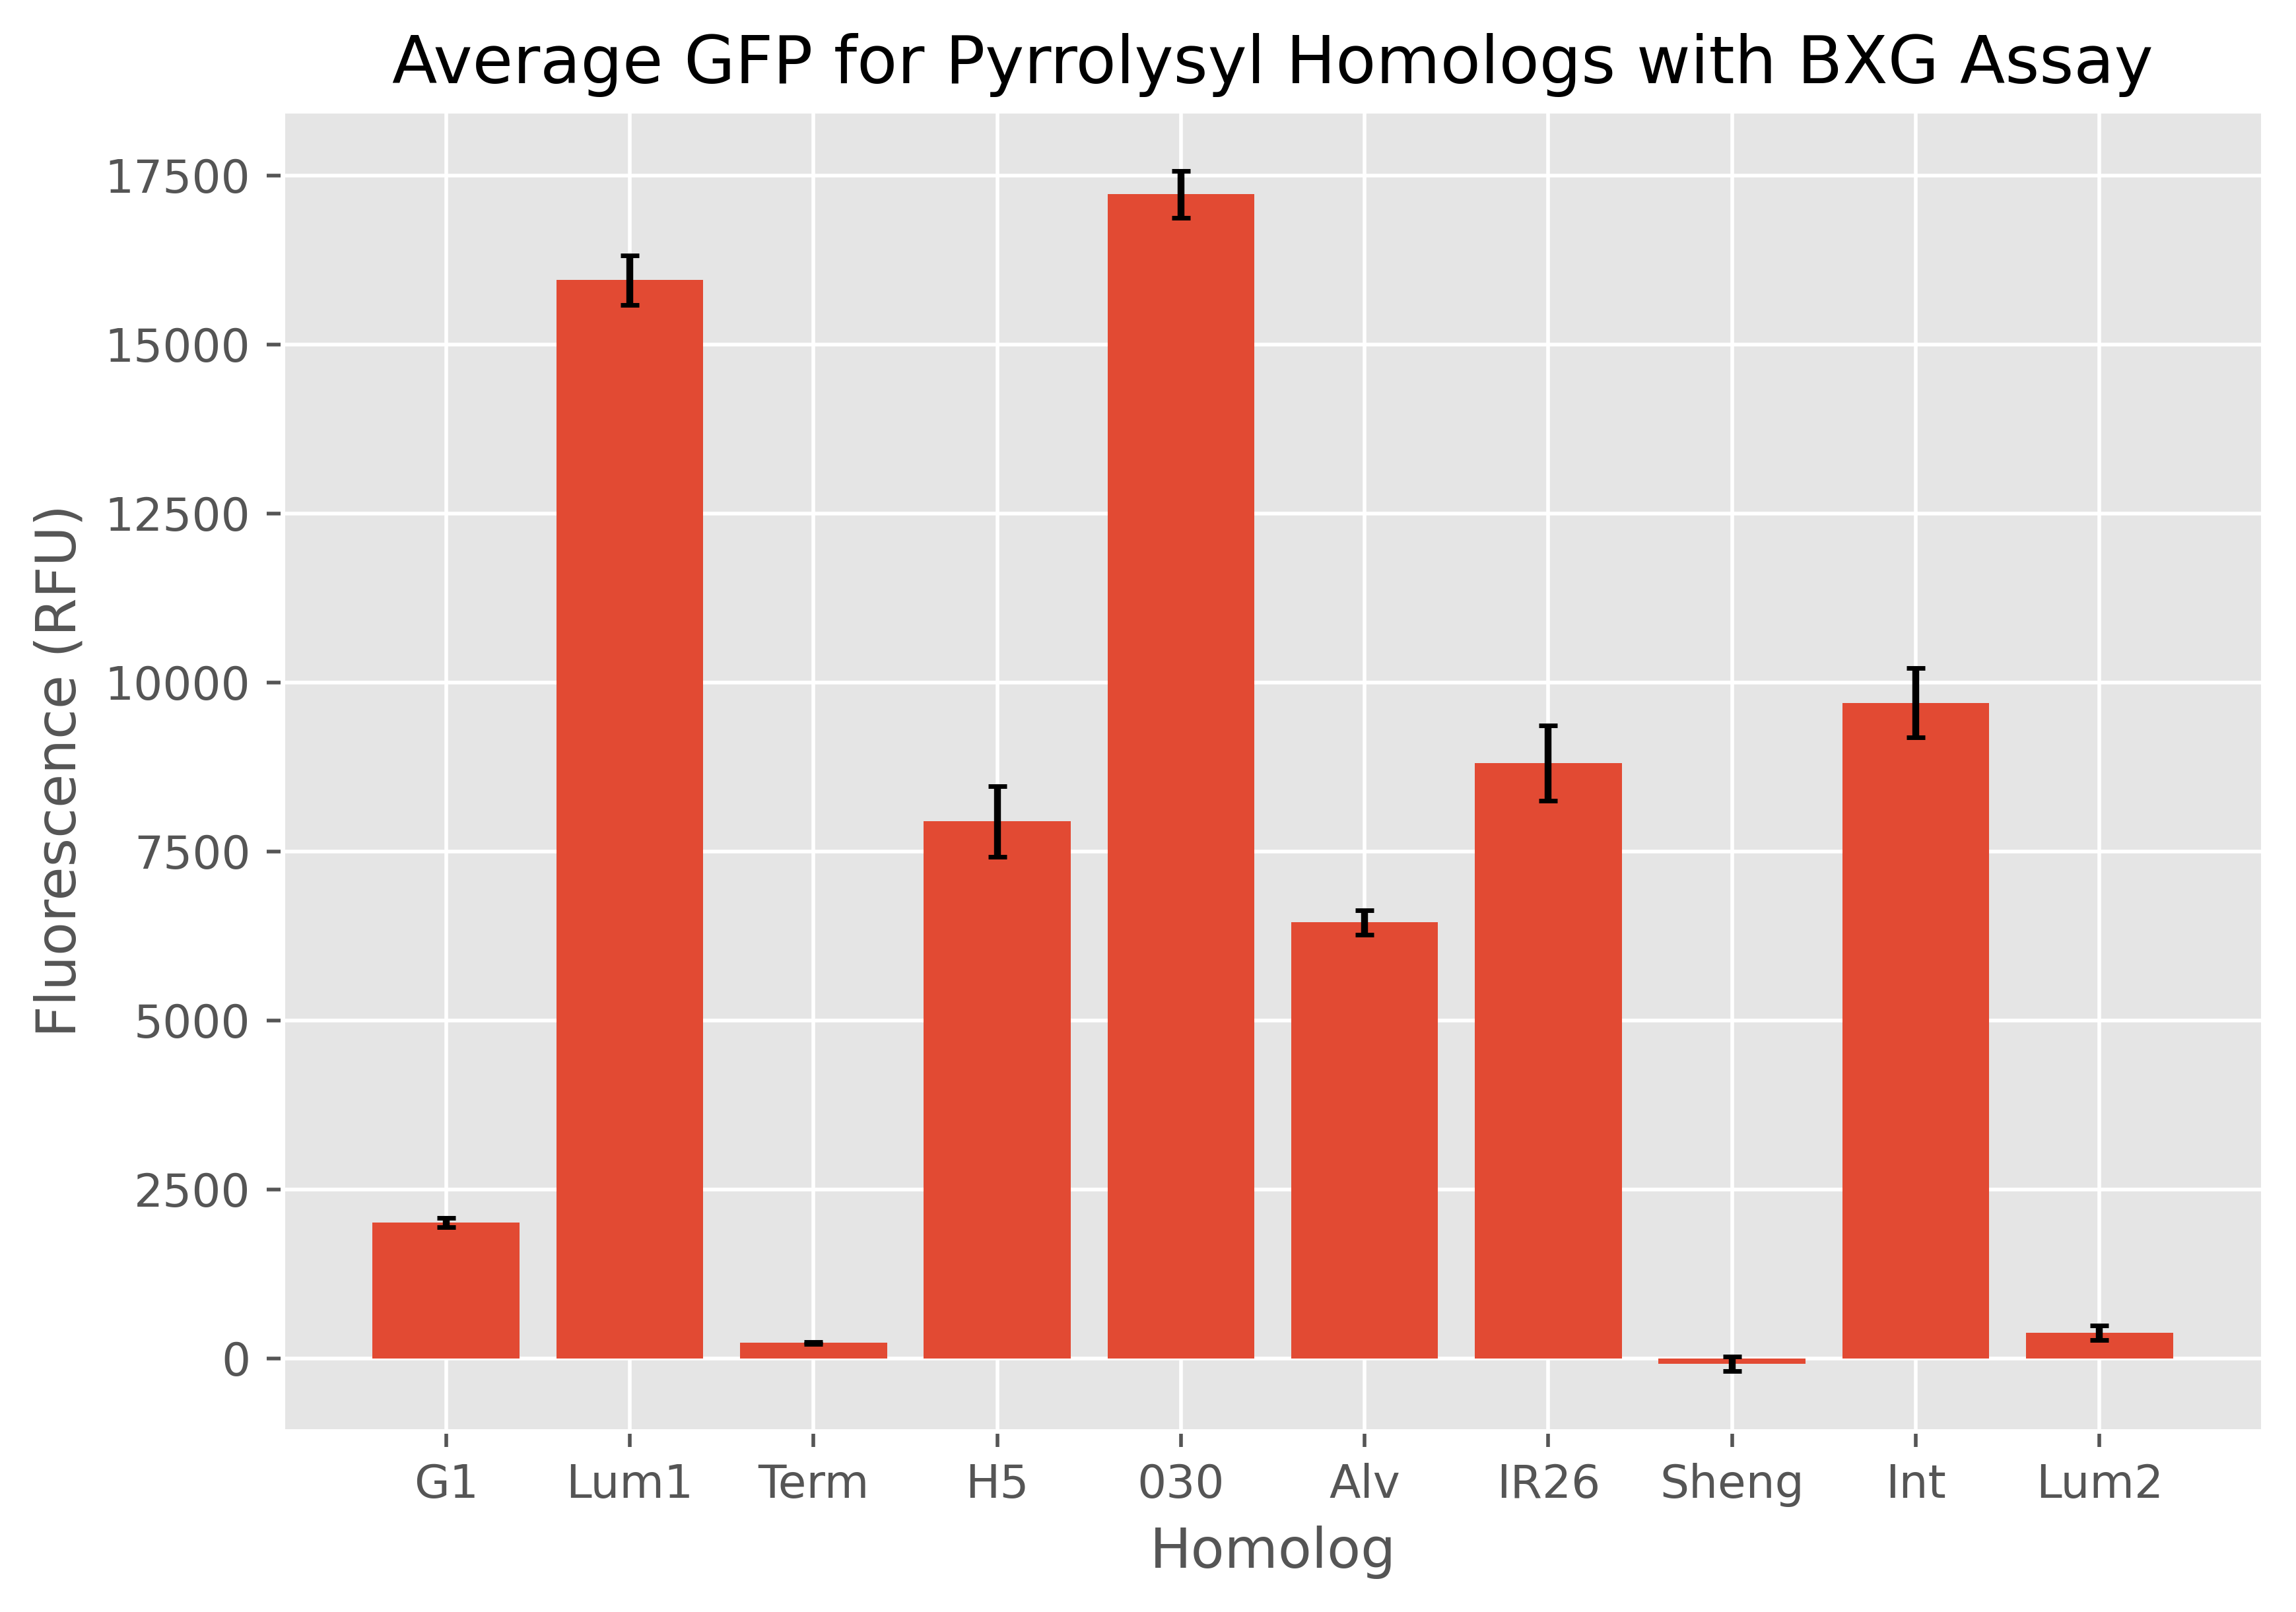

In [140]:
# Plotting the graph
import numpy as np 
import matplotlib.pyplot as plt 
import math

plt.style.use('ggplot')

def variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n 
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

def stdev(data): 
    var = variance(data)
    std_dev = math.sqrt(var)
    return std_dev

def barchartGFPEndTime(endTimeData, backgroundWells, wells, labels, title):
    
    # Calculate average background for BFP and GFP 
    avgBFP = 0 
    avgGFP = 0 
    for well in backgroundWells: 
        avgBFP += endTimeData[well][0]
        avgGFP += endTimeData[well][1]
    avgBFP = avgBFP / len(backgroundWells)
    avgGFP = avgGFP / len(backgroundWells)
    
    # Calculate average for input wells 
    wellAvgSeries = [] # [ (experiment 1 BFP average, experiment 1 GFP average), (experiment 2 BFP average, experiment 2 GFP average), ... , ]
    for experiment in wells:
        tmpAvgBFP = 0 
        tmpAvgGFP = 0
        count = 0 
        for replicate in experiment:
            tmpAvgBFP += endTimeData[replicate][0]
            tmpAvgGFP += endTimeData[replicate][1]
            count += 1
        
        expAvgBFP = tmpAvgBFP / count
        expAvgGFP = tmpAvgGFP / count
        
        wellAvgSeries.append((expAvgBFP, expAvgGFP))
            
    # Calculate stdev series for experiments 
    stdevSeries = [] # Holds stdev scores for BFP and GFP experiments in form [ (experiment 1 stdev BFP, experiment 1 stdev GFP ), (experiment 2 stdev BFP, experiment 2 stdev GFP) ...  ]
    for experiment in wells:
        scoresBFP = []
        scoresGFP = []
        for replicate in experiment: 
            scoresBFP.append(endTimeData[replicate][0])
            scoresGFP.append(endTimeData[replicate][1])
        stdevBFP = stdev(scoresBFP)
        stdevGFP = stdev(scoresGFP)
        stdevSeries.append((stdevBFP, stdevGFP))
       

    # Form the background substracted series
    subtractedSeries = [] # [ (exp1 BFP subtracted, exp1 GFP substracted), (exp2 BFP sub, exp2 GFP sub), ..., ]
    for data in wellAvgSeries:
        subBFP = data[0] - avgBFP
        subGFP = data[1] - avgGFP
        subtractedSeries.append((subBFP, subGFP))
        
    # Calculate error series from substratacted data (upper and lower bounds as dicatated from standard deviation)
    errorSeriesBFP = [] # Holds lower and upper bounds of replicates [  (experiment 1 low bound, experiment 1 high bound), (experiemnt 2 low bound, experiment 2 high bound), ...  ]
    errorSeriesGFP = []
    for data, error in zip(subtractedSeries, stdevSeries):
        bfpLow = data[0] - error[0]
        bfpHigh = data[0] + error[0]
        
        gfpLow = data[1] - error[1]
        gfpHigh = data[1] + error[1]
        
        errorSeriesBFP.append((bfpLow, bfpHigh))
        errorSeriesGFP.append((gfpLow, gfpHigh))

    # Seperate out the data
    bfpSeries = [] # in order of experiment listed 
    gfpSeries = []
    bfpErrorSeries = []
    gfpErrorSeries = []
    for experiment, error in zip(subtractedSeries, stdevSeries): 
        bfpSeries.append(experiment[0])
        gfpSeries.append(experiment[1])
        bfpErrorSeries.append(error[0])
        gfpErrorSeries.append(error[1])
    
   
    
    # Plot the graph 
    fig = plt.figure(dpi=500)
    x = np.arange(len(labels))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.bar(labels, gfpSeries, yerr=gfpErrorSeries, capsize=2)
    ax.set_xlabel('Homolog')
    ax.set_ylabel('Fluorescence (RFU)')
    plt.title(title)
    plt.show()
    

barchartGFPEndTime(endTimeData, ['A1'], [['E1', 'F1', 'G1'], ['E2', 'F2', 'G2'], ['E3', 'F3', 'G3'], ['E4', 'F4', 'G4'], ['E5', 'F5', 'G5'], ['E6', 'F6', 'G6'], ['E7', 'F7', 'G7'], ['E8', 'F8', 'G8'], ['E9', 'F9', 'G9'], ['E10', 'F10', 'G10'] ] , ['G1', 'Lum1', 'Term', 'H5', '030', 'Alv', 'IR26', 'Sheng', 'Int', 'Lum2'], title = 'Average GFP for Pyrrolysyl Homologs with BXG Assay')

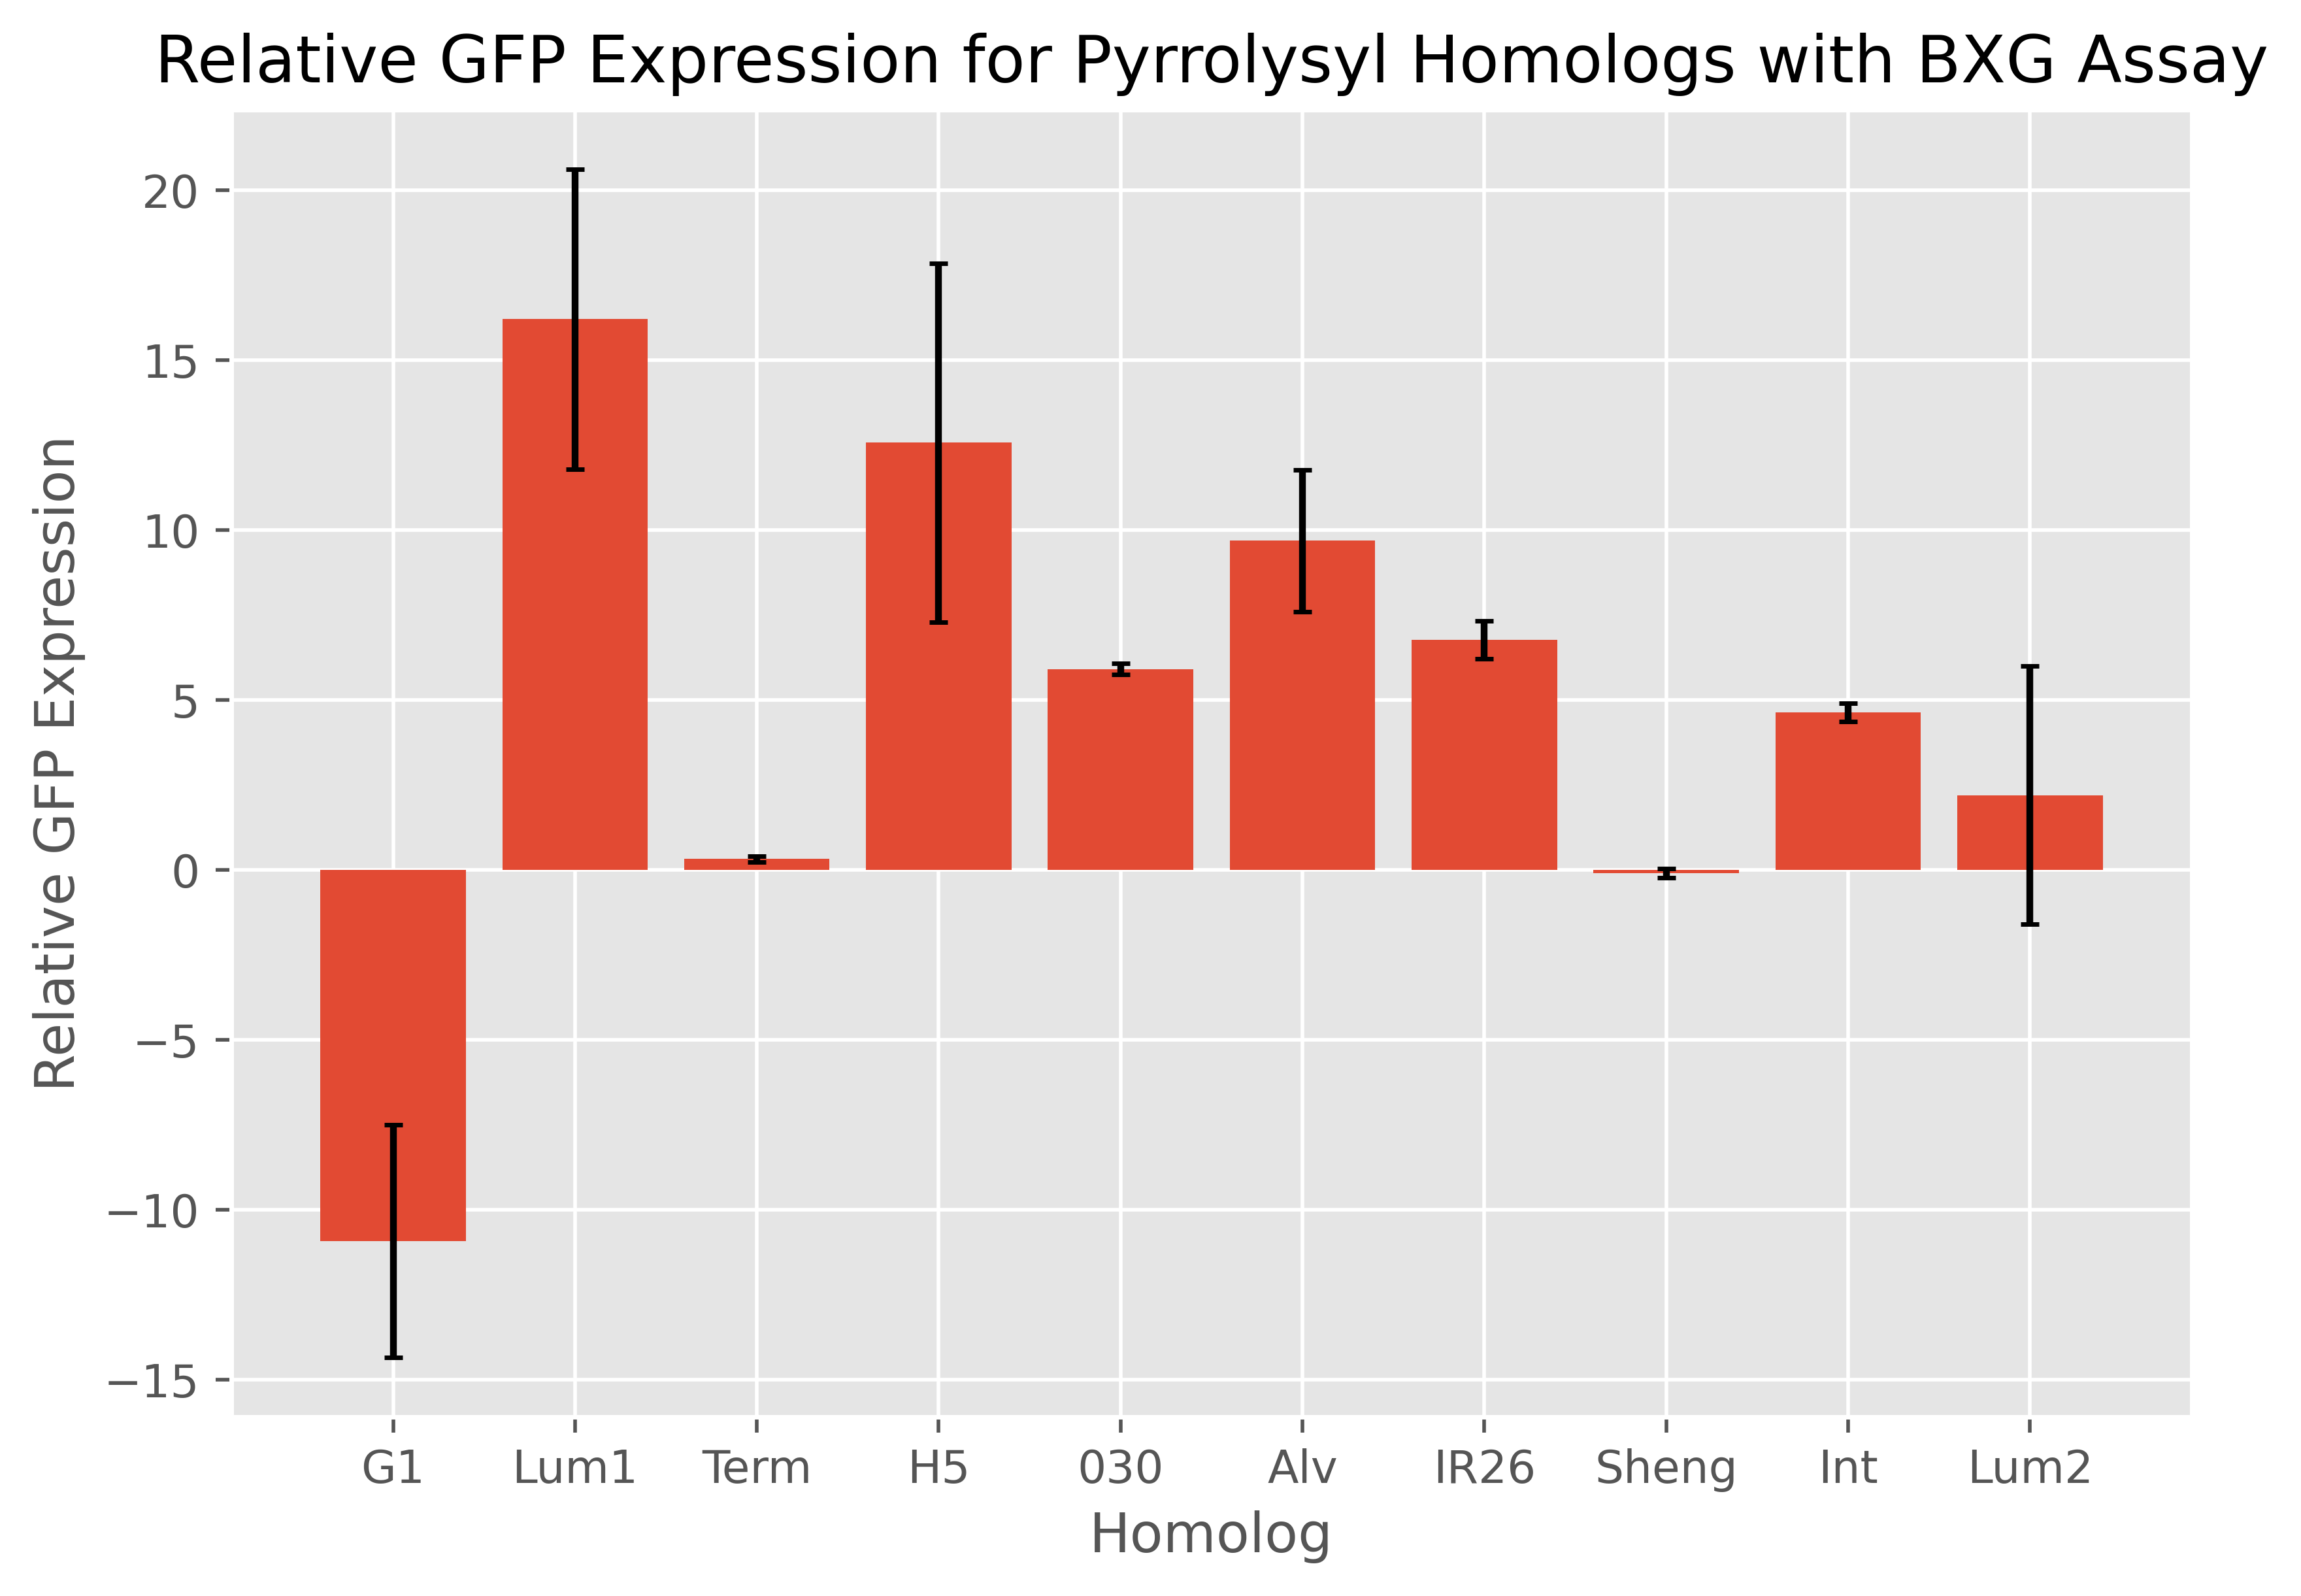

In [86]:
def barchartGFPRelative(endTimeData, backgroundWells, wells, labels, title):
    
    # Calculate average background for BFP and GFP 
    avgBFP = 0 
    avgGFP = 0 
    for well in backgroundWells: 
        avgBFP += endTimeData[well][0]
        avgGFP += endTimeData[well][1]
    avgBFP = avgBFP / len(backgroundWells)
    avgGFP = avgGFP / len(backgroundWells)
    
    # Calculate average for input wells 
    wellAvgSeries = [] # [ (experiment 1 BFP average, experiment 1 GFP average), (experiment 2 BFP average, experiment 2 GFP average), ... , ]
    for experiment in wells:
        tmpAvgBFP = 0 
        tmpAvgGFP = 0
        count = 0 
        for replicate in experiment:
            tmpAvgBFP += endTimeData[replicate][0]
            tmpAvgGFP += endTimeData[replicate][1]
            count += 1
        
        expAvgBFP = tmpAvgBFP / count
        expAvgGFP = tmpAvgGFP / count
        
        wellAvgSeries.append((expAvgBFP, expAvgGFP))
            
    # Calculate stdev series for experiments 
    stdevSeries = [] # Holds stdev scores for BFP and GFP experiments in form [ (experiment 1 stdev BFP, experiment 1 stdev GFP ), (experiment 2 stdev BFP, experiment 2 stdev GFP) ...  ]
    for experiment in wells:
        scoresBFP = []
        scoresGFP = []
        for replicate in experiment: 
            scoresBFP.append(endTimeData[replicate][0])
            scoresGFP.append(endTimeData[replicate][1])
        stdevBFP = stdev(scoresBFP)
        stdevGFP = stdev(scoresGFP)
        stdevSeries.append((stdevBFP, stdevGFP))
       

    # Form the background substracted series
    subtractedSeries = [] # [ (exp1 BFP subtracted, exp1 GFP substracted), (exp2 BFP sub, exp2 GFP sub), ..., ]
    for data in wellAvgSeries:
        subBFP = data[0] - avgBFP
        subGFP = data[1] - avgGFP
        subtractedSeries.append((subBFP, subGFP))
        
    # Calculate error series from substratacted data (upper and lower bounds as dicatated from standard deviation)
    errorSeriesBFP = [] # Holds lower and upper bounds of replicates [  (experiment 1 low bound, experiment 1 high bound), (experiemnt 2 low bound, experiment 2 high bound), ...  ]
    errorSeriesGFP = []
    for data, error in zip(subtractedSeries, stdevSeries):
        bfpLow = data[0] - error[0]
        bfpHigh = data[0] + error[0]
        
        gfpLow = data[1] - error[1]
        gfpHigh = data[1] + error[1]
        
        errorSeriesBFP.append((bfpLow, bfpHigh))
        errorSeriesGFP.append((gfpLow, gfpHigh))

    # Seperate out the data
    bfpSeries = [] # in order of experiment listed 
    gfpSeries = []
    bfpErrorSeries = []
    gfpErrorSeries = []
    for experiment, error in zip(subtractedSeries, stdevSeries): 
        bfpSeries.append(experiment[0])
        gfpSeries.append(experiment[1])
        bfpErrorSeries.append(error[0])
        gfpErrorSeries.append(error[1])
    
   
    gfpRelativeSeries = []
    for data in subtractedSeries:
        relativeScore = data[1] / data[0]
        gfpRelativeSeries.append(relativeScore)

    def errorPropagation(bfpSeries, bfpError, gfpSeries, gfpError, gfpRelativeSeries):
        
        # Calculating propagation of error from division - reference https://www.geol.lsu.edu/jlorenzo/geophysics/uncertainties/Uncertaintiespart2.html 
        gfpRelativeErrorSeries = []
        for bfp, bfpError, gfp, gfpError, gfpRelative in zip(bfpSeries, bfpErrorSeries, gfpSeries, gfpErrorSeries, gfpRelativeSeries):
            gfpRelativeError = gfpRelative * (math.sqrt(((gfpError / gfp)**2) + ((bfpError/bfp)**2)))
            gfpRelativeErrorSeries.append(gfpRelativeError)
        
        return gfpRelativeErrorSeries
            
    gfpRelativeErrorSeries = errorPropagation(bfpSeries, bfpErrorSeries, gfpSeries, gfpErrorSeries, gfpRelativeSeries)
    
        
    
    # Plot the graph 
    fig = plt.figure(dpi=500)
    x = np.arange(len(labels))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.bar(labels, gfpRelativeSeries, yerr=gfpRelativeErrorSeries, capsize=2)
    ax.set_xlabel('Homolog')
    ax.set_ylabel('Relative GFP Expression')
    plt.title(title)
    plt.show()
    

barchartGFPRelative(endTimeData, ['A1'], [['E1', 'F1', 'G1'], ['E2', 'F2', 'G2'], ['E3', 'F3', 'G3'], ['E4', 'F4', 'G4'], ['E5', 'F5', 'G5'], ['E6', 'F6', 'G6'], ['E7', 'F7', 'G7'], ['E8', 'F8', 'G8'], ['E9', 'F9', 'G9'], ['E10', 'F10', 'G10'] ] , ['G1', 'Lum1', 'Term', 'H5', '030', 'Alv', 'IR26', 'Sheng', 'Int', 'Lum2'], title = 'Relative GFP Expression for Pyrrolysyl Homologs with BXG Assay')

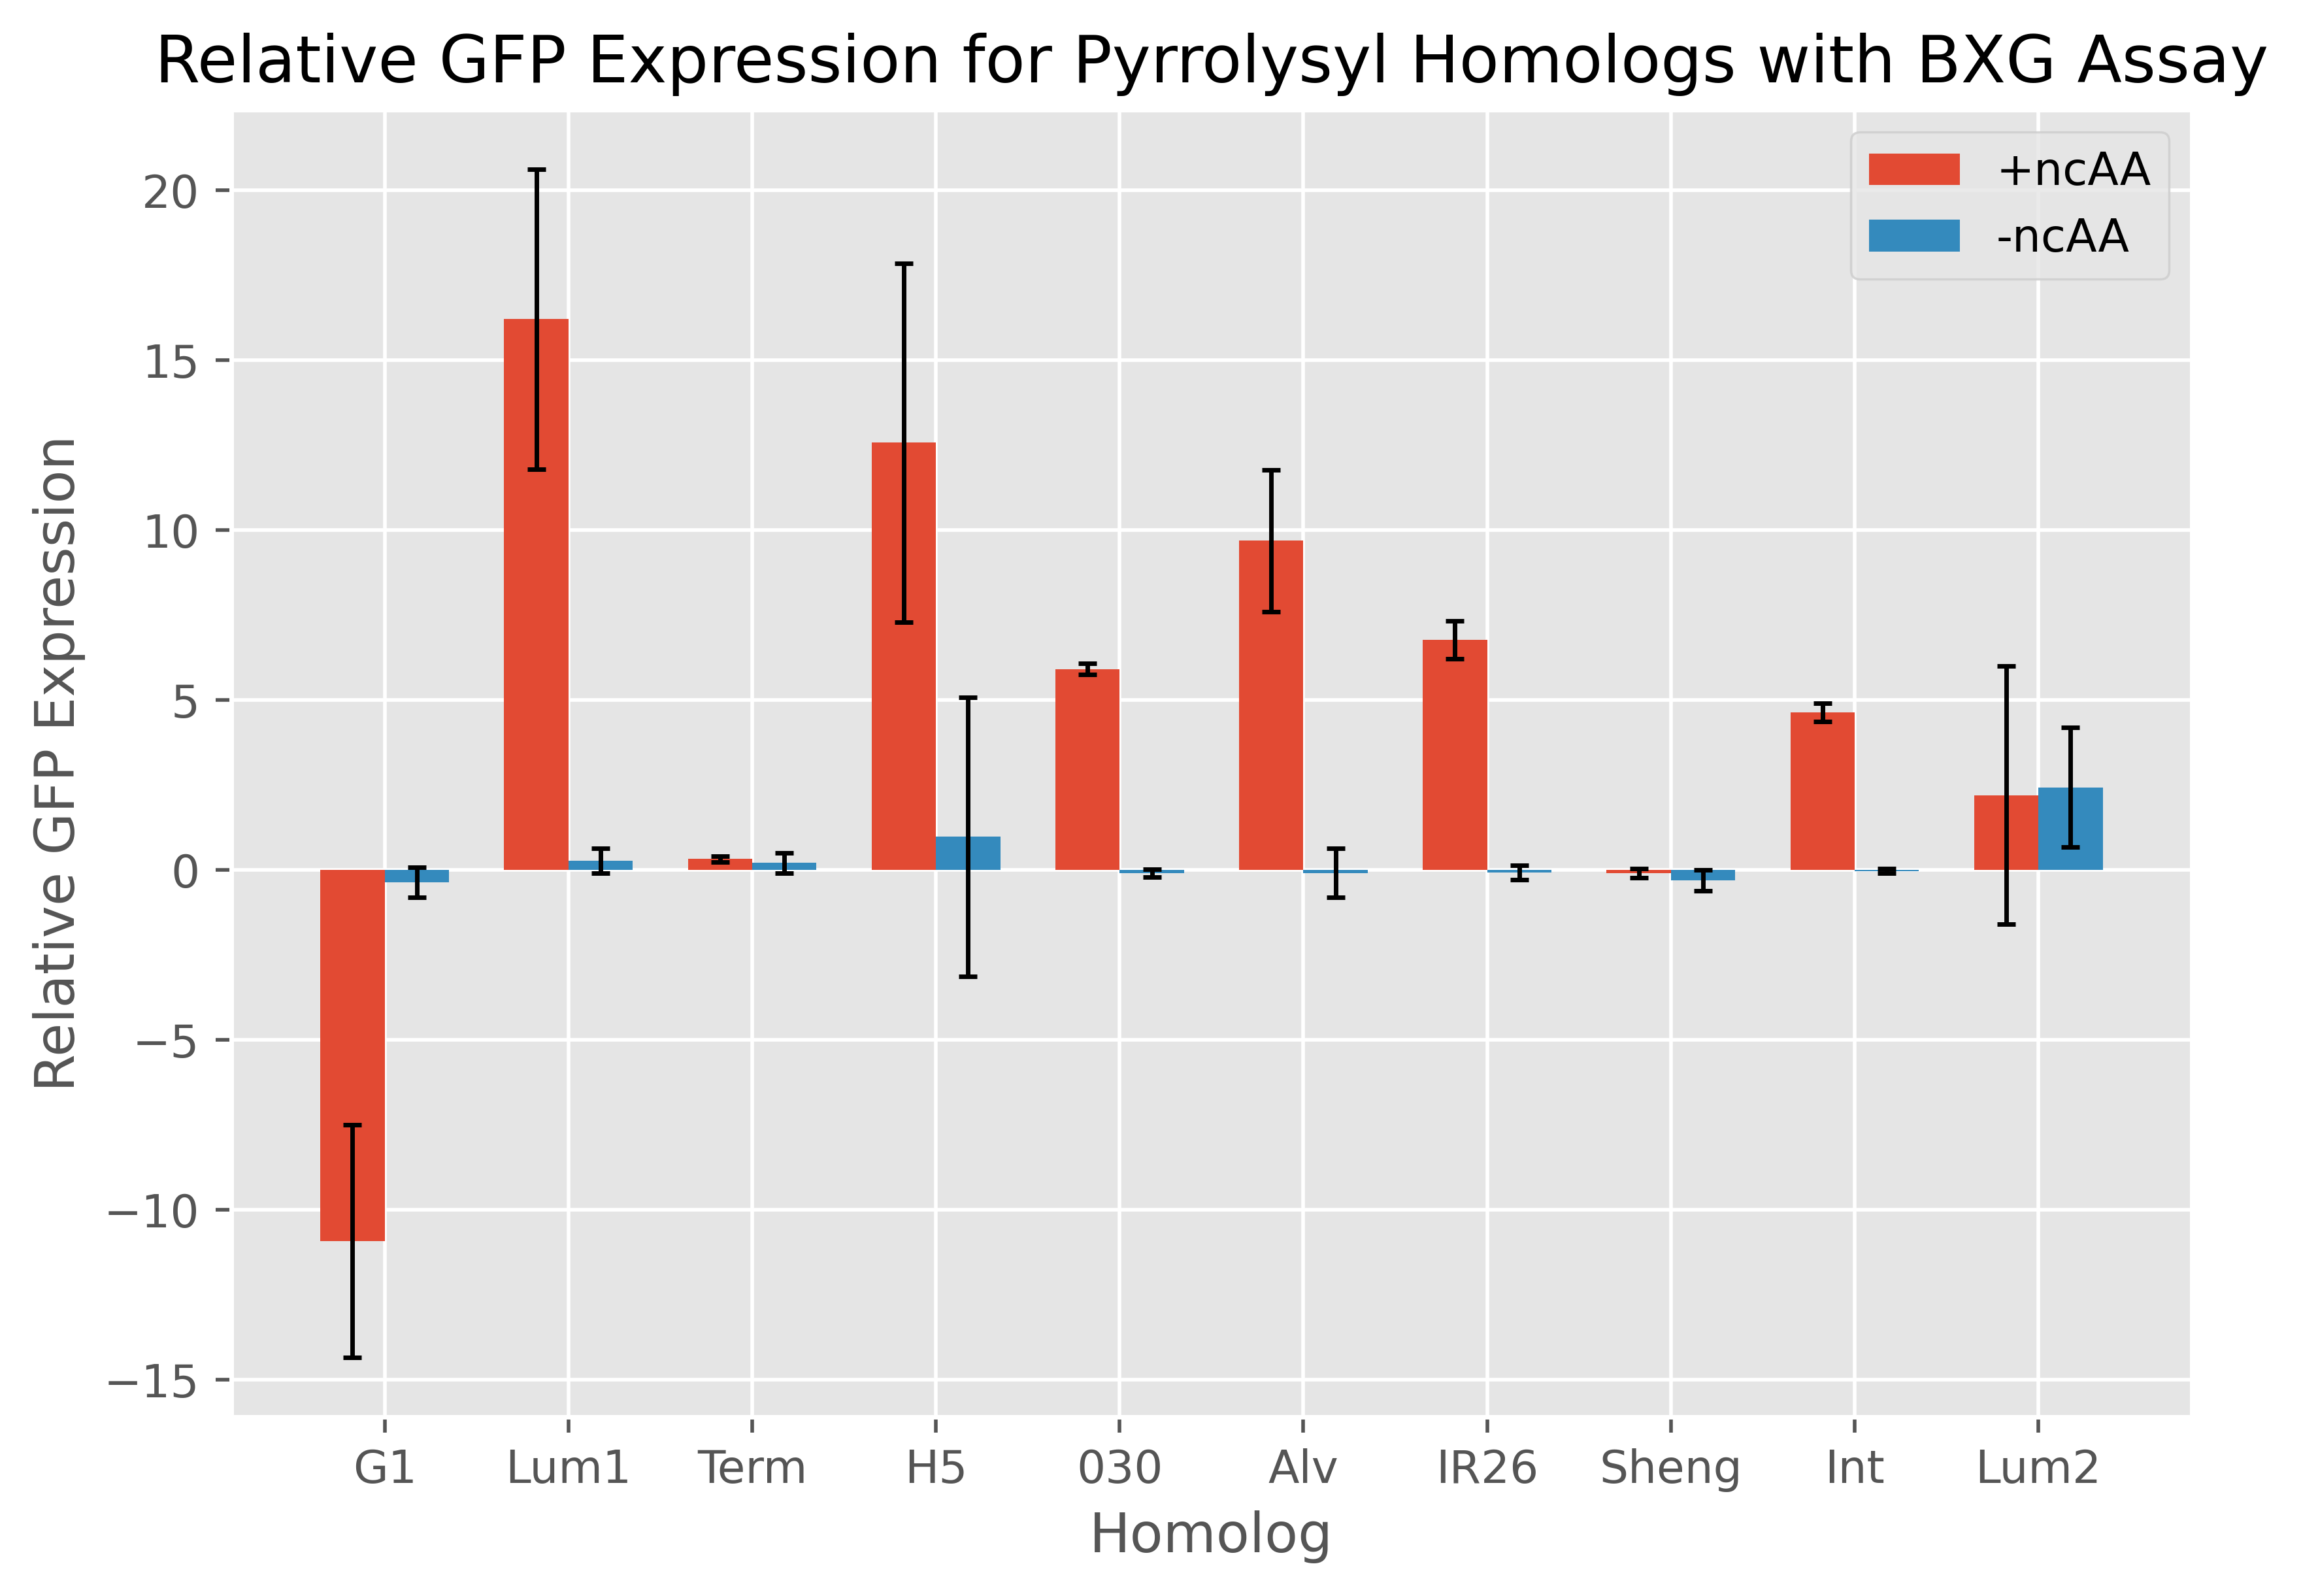

In [133]:
def processData(endTimeData, backgroundWells, wells):
    
    # Calculate average background for BFP and GFP 
    avgBFP = 0 
    avgGFP = 0 
    for well in backgroundWells: 
        avgBFP += endTimeData[well][0]
        avgGFP += endTimeData[well][1]
    avgBFP = avgBFP / len(backgroundWells)
    avgGFP = avgGFP / len(backgroundWells)
    
    # Calculate average for input wells 
    wellAvgSeries = [] # [ (experiment 1 BFP average, experiment 1 GFP average), (experiment 2 BFP average, experiment 2 GFP average), ... , ]
    for experiment in wells:
        tmpAvgBFP = 0 
        tmpAvgGFP = 0
        count = 0 
        for replicate in experiment:
            tmpAvgBFP += endTimeData[replicate][0]
            tmpAvgGFP += endTimeData[replicate][1]
            count += 1
        
        expAvgBFP = tmpAvgBFP / count
        expAvgGFP = tmpAvgGFP / count
        
        wellAvgSeries.append((expAvgBFP, expAvgGFP))
            
    # Calculate stdev series for experiments 
    stdevSeries = [] # Holds stdev scores for BFP and GFP experiments in form [ (experiment 1 stdev BFP, experiment 1 stdev GFP ), (experiment 2 stdev BFP, experiment 2 stdev GFP) ...  ]
    for experiment in wells:
        scoresBFP = []
        scoresGFP = []
        for replicate in experiment: 
            scoresBFP.append(endTimeData[replicate][0])
            scoresGFP.append(endTimeData[replicate][1])
        stdevBFP = stdev(scoresBFP)
        stdevGFP = stdev(scoresGFP)
        stdevSeries.append((stdevBFP, stdevGFP))
       

    # Form the background substracted series
    subtractedSeries = [] # [ (exp1 BFP subtracted, exp1 GFP substracted), (exp2 BFP sub, exp2 GFP sub), ..., ]
    for data in wellAvgSeries:
        subBFP = data[0] - avgBFP
        subGFP = data[1] - avgGFP
        subtractedSeries.append((subBFP, subGFP))
        
    # Calculate error series from substratacted data (upper and lower bounds as dicatated from standard deviation)
    errorSeriesBFP = [] # Holds lower and upper bounds of replicates [  (experiment 1 low bound, experiment 1 high bound), (experiemnt 2 low bound, experiment 2 high bound), ...  ]
    errorSeriesGFP = []
    for data, error in zip(subtractedSeries, stdevSeries):
        bfpLow = data[0] - error[0]
        bfpHigh = data[0] + error[0]
        
        gfpLow = data[1] - error[1]
        gfpHigh = data[1] + error[1]
        
        errorSeriesBFP.append((bfpLow, bfpHigh))
        errorSeriesGFP.append((gfpLow, gfpHigh))

    # Seperate out the data
    bfpSeries = [] # in order of experiment listed 
    gfpSeries = []
    bfpErrorSeries = []
    gfpErrorSeries = []
    for experiment, error in zip(subtractedSeries, stdevSeries): 
        bfpSeries.append(experiment[0])
        gfpSeries.append(experiment[1])
        bfpErrorSeries.append(error[0])
        gfpErrorSeries.append(error[1])
    
   
    gfpRelativeSeries = []
    for data in subtractedSeries:
        relativeScore = data[1] / data[0]
        gfpRelativeSeries.append(relativeScore)

    def errorPropagation(bfpSeries, bfpError, gfpSeries, gfpError, gfpRelativeSeries):
        
        # Calculating propagation of error from division - reference https://www.geol.lsu.edu/jlorenzo/geophysics/uncertainties/Uncertaintiespart2.html 
        gfpRelativeErrorSeries = []
        for bfp, bfpError, gfp, gfpError, gfpRelative in zip(bfpSeries, bfpErrorSeries, gfpSeries, gfpErrorSeries, gfpRelativeSeries):
            gfpRelativeError = gfpRelative * (math.sqrt(((gfpError / gfp)**2) + ((bfpError/bfp)**2)))
            gfpRelativeErrorSeries.append(gfpRelativeError)
        
        return gfpRelativeErrorSeries
            
    gfpRelativeErrorSeries = errorPropagation(bfpSeries, bfpErrorSeries, gfpSeries, gfpErrorSeries, gfpRelativeSeries)
    
        
    return bfpSeries, bfpErrorSeries, gfpSeries, gfpErrorSeries, gfpRelativeSeries, gfpRelativeErrorSeries

def barchartGFPRelativeComparitive(endTimeData, backgroundWells, wellsPositive, wellsNegative, labels, title):
    
    positiveWellData = processData(endTimeData, backgroundWells, wellsPositive )
    negativeWellData = processData(endTimeData, backgroundWells, wellsNegative)
    
    positiveRelativeGFPSeries = positiveWellData[4]
    positiveRelativeGFPErrorSeries = positiveWellData[5]

    negativeRelativeGFPSeries = negativeWellData[4]
    negativeRelativeGFPErrorSeries = negativeWellData[5]
    
    
    # Plot the graph 
    fig = plt.figure(dpi=500)
    x = np.arange(len(labels))
    width = 0.35
    ax = fig.add_axes([0, 0, 1, 1])
    positiveBar = ax.bar( x - width/2, positiveRelativeGFPSeries, width, label='+ncAA', yerr=positiveRelativeGFPErrorSeries, error_kw=dict(lw=1, capsize=2, capthick=1))
    negativeBar = ax.bar( x + width/2, negativeRelativeGFPSeries, width, label='-ncAA', yerr=negativeRelativeGFPErrorSeries, error_kw=dict(lw=1, capsize=2, capthick=1))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Homolog')
    ax.set_ylabel('Relative GFP Expression')
    plt.title(title)
    ax.legend()
    plt.show()


barchartGFPRelativeComparitive(endTimeData, ['A1'], [['E1', 'F1', 'G1'], ['E2', 'F2', 'G2'], ['E3', 'F3', 'G3'], ['E4', 'F4', 'G4'], ['E5', 'F5', 'G5'], ['E6', 'F6', 'G6'], ['E7', 'F7', 'G7'], ['E8', 'F8', 'G8'], ['E9', 'F9', 'G9'], ['E10', 'F10', 'G10'] ], 
                               [['A1', 'B1', 'C1'], ['A2', 'B2', 'C2'], ['A3', 'B3', 'C3'], ['A4', 'B4', 'C4'], ['A5', 'B5', 'C5'], ['A6', 'B6', 'C6'], ['A7', 'B7', 'C7'], ['A8', 'B8', 'C8'], ['A9', 'B9', 'C9'], ['A10', 'B10', 'C10'] ]
                               , ['G1', 'Lum1', 'Term', 'H5', '030', 'Alv', 'IR26', 'Sheng', 'Int', 'Lum2'], title = 'Relative GFP Expression for Pyrrolysyl Homologs with BXG Assay')

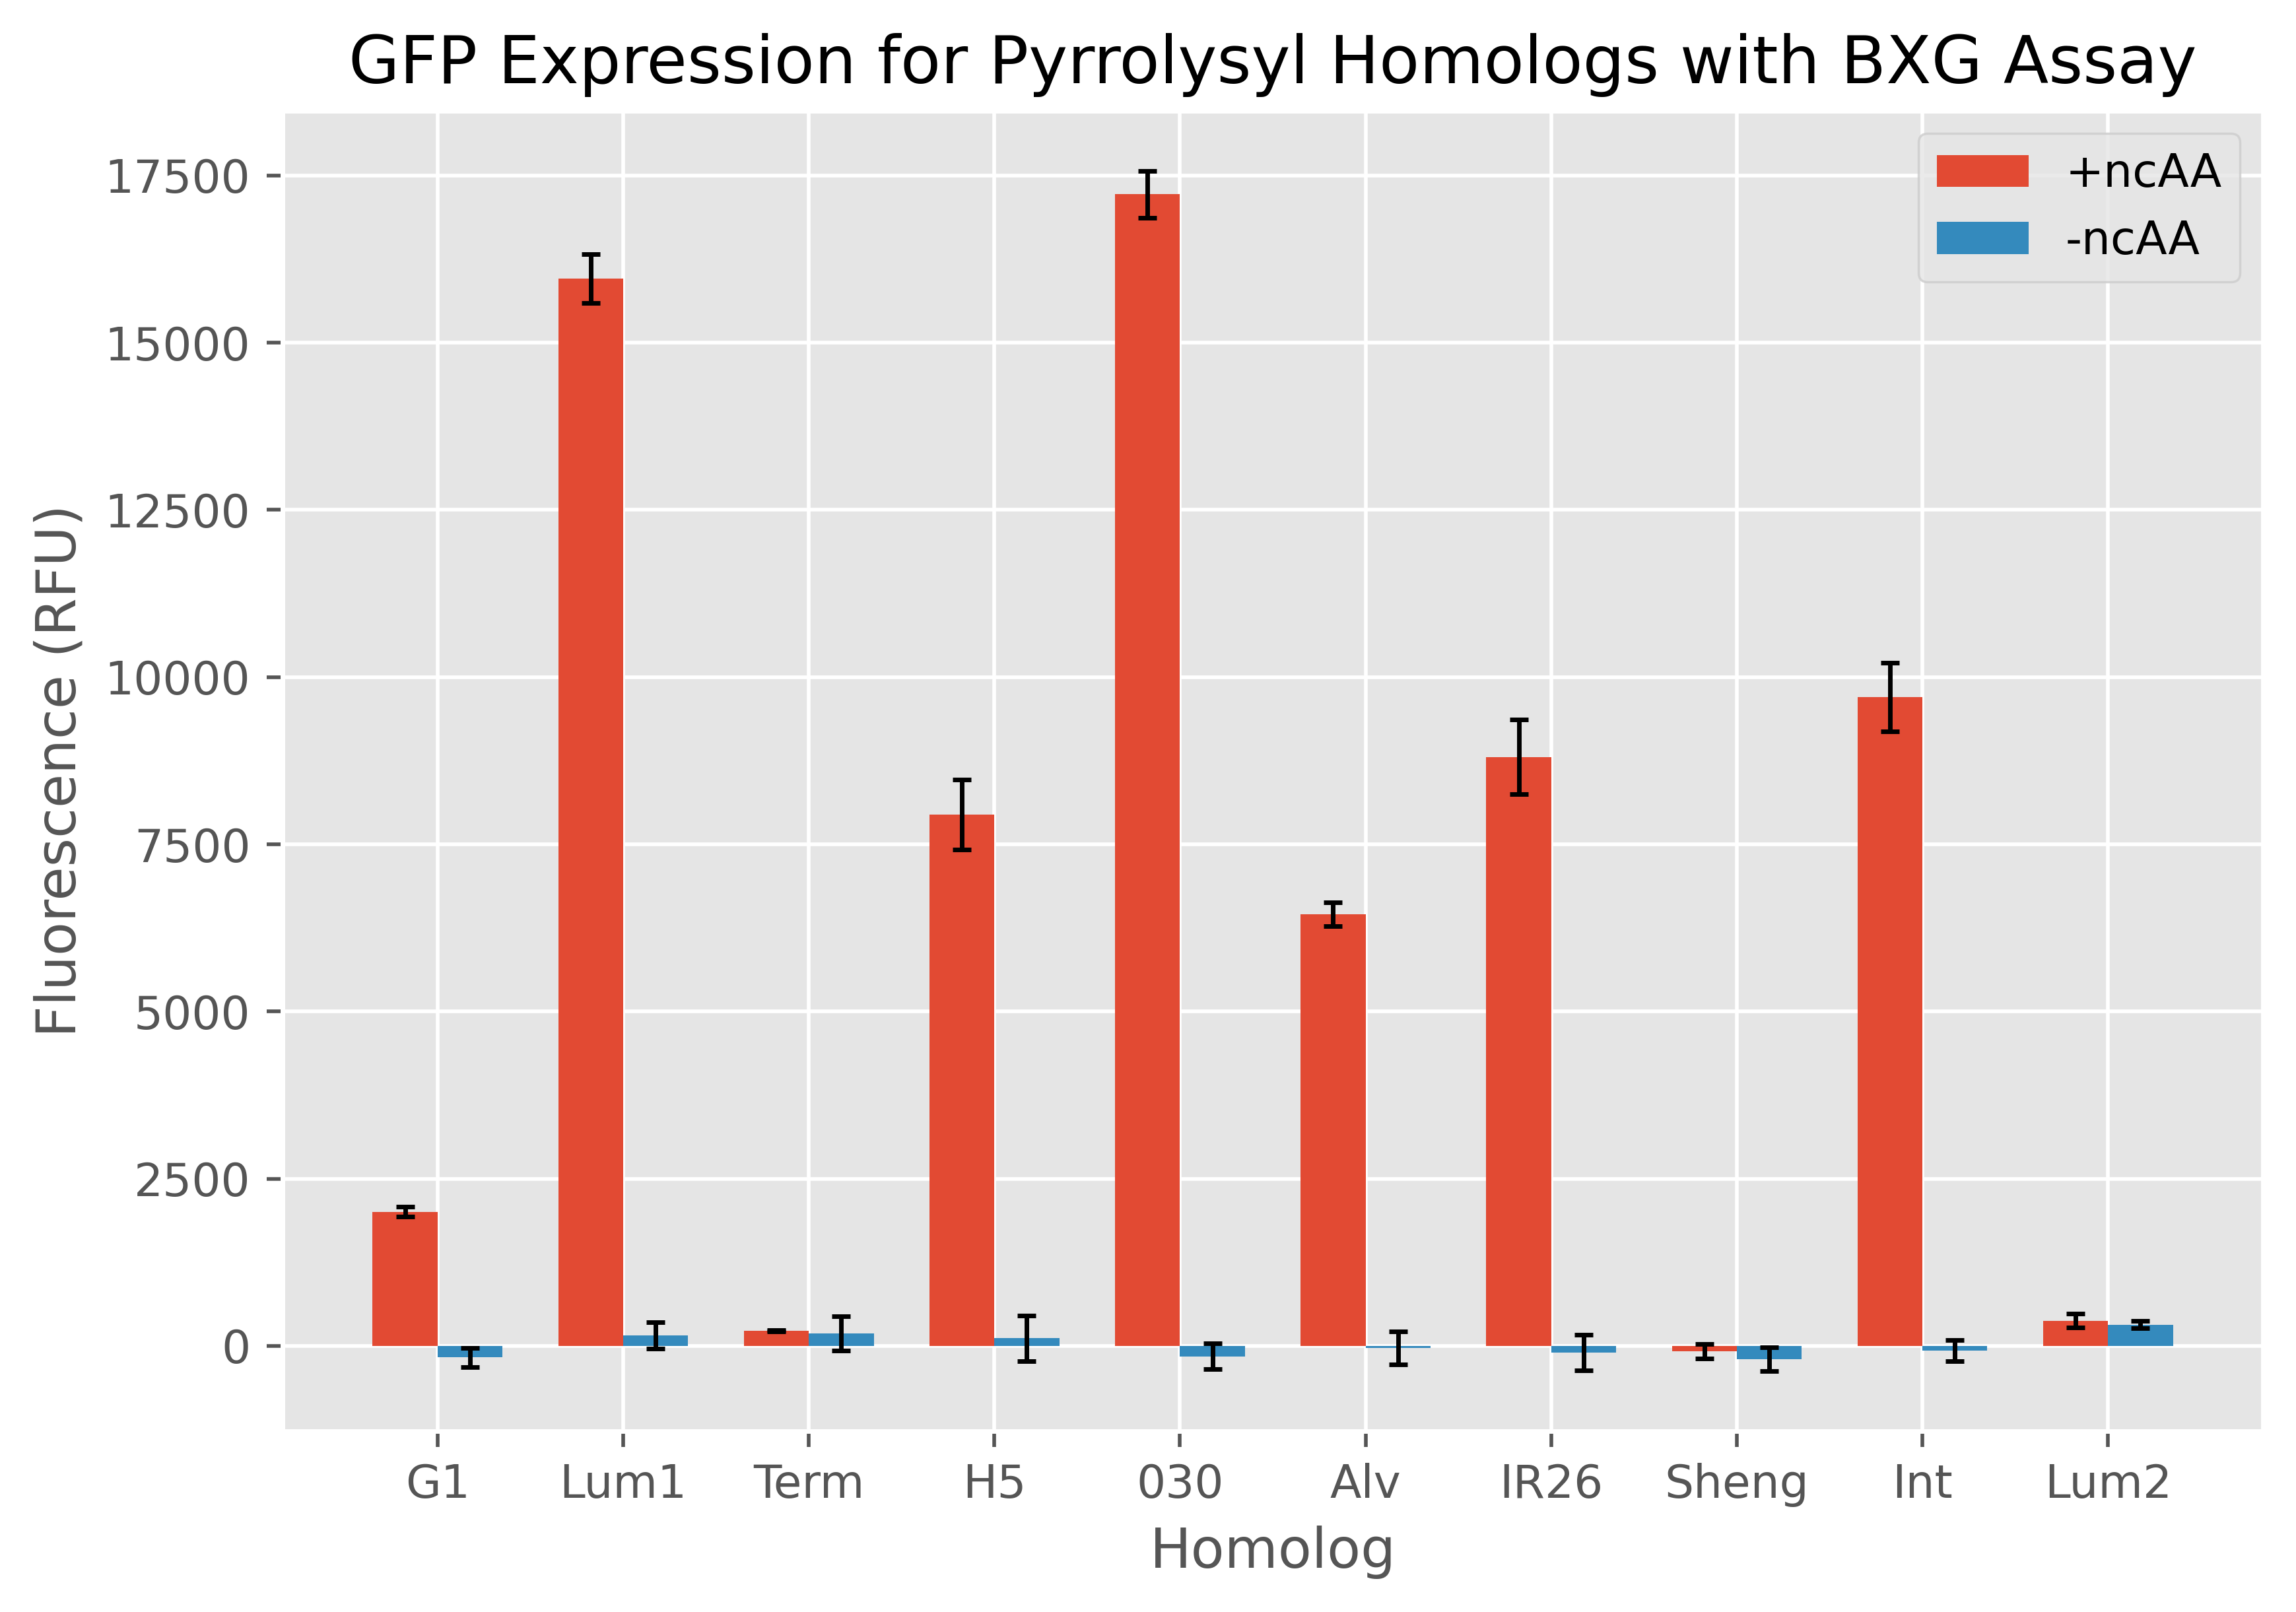

In [138]:
def processData(endTimeData, backgroundWells, wells):
    
    # Calculate average background for BFP and GFP 
    avgBFP = 0 
    avgGFP = 0 
    for well in backgroundWells: 
        avgBFP += endTimeData[well][0]
        avgGFP += endTimeData[well][1]
    avgBFP = avgBFP / len(backgroundWells)
    avgGFP = avgGFP / len(backgroundWells)
    
    # Calculate average for input wells 
    wellAvgSeries = [] # [ (experiment 1 BFP average, experiment 1 GFP average), (experiment 2 BFP average, experiment 2 GFP average), ... , ]
    for experiment in wells:
        tmpAvgBFP = 0 
        tmpAvgGFP = 0
        count = 0 
        for replicate in experiment:
            tmpAvgBFP += endTimeData[replicate][0]
            tmpAvgGFP += endTimeData[replicate][1]
            count += 1
        
        expAvgBFP = tmpAvgBFP / count
        expAvgGFP = tmpAvgGFP / count
        
        wellAvgSeries.append((expAvgBFP, expAvgGFP))
            
    # Calculate stdev series for experiments 
    stdevSeries = [] # Holds stdev scores for BFP and GFP experiments in form [ (experiment 1 stdev BFP, experiment 1 stdev GFP ), (experiment 2 stdev BFP, experiment 2 stdev GFP) ...  ]
    for experiment in wells:
        scoresBFP = []
        scoresGFP = []
        for replicate in experiment: 
            scoresBFP.append(endTimeData[replicate][0])
            scoresGFP.append(endTimeData[replicate][1])
        stdevBFP = stdev(scoresBFP)
        stdevGFP = stdev(scoresGFP)
        stdevSeries.append((stdevBFP, stdevGFP))
       

    # Form the background substracted series
    subtractedSeries = [] # [ (exp1 BFP subtracted, exp1 GFP substracted), (exp2 BFP sub, exp2 GFP sub), ..., ]
    for data in wellAvgSeries:
        subBFP = data[0] - avgBFP
        subGFP = data[1] - avgGFP
        subtractedSeries.append((subBFP, subGFP))
        
    # Calculate error series from substratacted data (upper and lower bounds as dicatated from standard deviation)
    errorSeriesBFP = [] # Holds lower and upper bounds of replicates [  (experiment 1 low bound, experiment 1 high bound), (experiemnt 2 low bound, experiment 2 high bound), ...  ]
    errorSeriesGFP = []
    for data, error in zip(subtractedSeries, stdevSeries):
        bfpLow = data[0] - error[0]
        bfpHigh = data[0] + error[0]
        
        gfpLow = data[1] - error[1]
        gfpHigh = data[1] + error[1]
        
        errorSeriesBFP.append((bfpLow, bfpHigh))
        errorSeriesGFP.append((gfpLow, gfpHigh))

    # Seperate out the data
    bfpSeries = [] # in order of experiment listed 
    gfpSeries = []
    bfpErrorSeries = []
    gfpErrorSeries = []
    for experiment, error in zip(subtractedSeries, stdevSeries): 
        bfpSeries.append(experiment[0])
        gfpSeries.append(experiment[1])
        bfpErrorSeries.append(error[0])
        gfpErrorSeries.append(error[1])
    
   
    gfpRelativeSeries = []
    for data in subtractedSeries:
        relativeScore = data[1] / data[0]
        gfpRelativeSeries.append(relativeScore)

    def errorPropagation(bfpSeries, bfpError, gfpSeries, gfpError, gfpRelativeSeries):
        
        # Calculating propagation of error from division - reference https://www.geol.lsu.edu/jlorenzo/geophysics/uncertainties/Uncertaintiespart2.html 
        gfpRelativeErrorSeries = []
        for bfp, bfpError, gfp, gfpError, gfpRelative in zip(bfpSeries, bfpErrorSeries, gfpSeries, gfpErrorSeries, gfpRelativeSeries):
            gfpRelativeError = gfpRelative * (math.sqrt(((gfpError / gfp)**2) + ((bfpError/bfp)**2)))
            gfpRelativeErrorSeries.append(gfpRelativeError)
        
        return gfpRelativeErrorSeries
            
    gfpRelativeErrorSeries = errorPropagation(bfpSeries, bfpErrorSeries, gfpSeries, gfpErrorSeries, gfpRelativeSeries)
    
        
    return bfpSeries, bfpErrorSeries, gfpSeries, gfpErrorSeries, gfpRelativeSeries, gfpRelativeErrorSeries

def barchartGFPComparitive(endTimeData, backgroundWells, wellsPositive, wellsNegative, labels, title):
    
    positiveWellData = processData(endTimeData, backgroundWells, wellsPositive )
    negativeWellData = processData(endTimeData, backgroundWells, wellsNegative)
    
    positiveGFPSeries = positiveWellData[2]
    positiveGFPErrorSeries = positiveWellData[3]

    negativeGFPSeries = negativeWellData[2]
    negativeGFPErrorSeries = negativeWellData[3]
    
    
    # Plot the graph 
    fig = plt.figure(dpi=500)
    x = np.arange(len(labels))
    width = 0.35
    ax = fig.add_axes([0, 0, 1, 1])
    positiveBar = ax.bar( x - width/2, positiveGFPSeries, width, label='+ncAA', yerr=positiveGFPErrorSeries, error_kw=dict(lw=1, capsize=2, capthick=1))
    negativeBar = ax.bar( x + width/2, negativeGFPSeries, width, label='-ncAA', yerr=negativeGFPErrorSeries, error_kw=dict(lw=1, capsize=2, capthick=1))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Homolog')
    ax.set_ylabel('Fluorescence (RFU)')
    plt.title(title)
    ax.legend()
    plt.show()


barchartGFPComparitive(endTimeData, ['A1'], [['E1', 'F1', 'G1'], ['E2', 'F2', 'G2'], ['E3', 'F3', 'G3'], ['E4', 'F4', 'G4'], ['E5', 'F5', 'G5'], ['E6', 'F6', 'G6'], ['E7', 'F7', 'G7'], ['E8', 'F8', 'G8'], ['E9', 'F9', 'G9'], ['E10', 'F10', 'G10'] ], 
                               [['A1', 'B1', 'C1'], ['A2', 'B2', 'C2'], ['A3', 'B3', 'C3'], ['A4', 'B4', 'C4'], ['A5', 'B5', 'C5'], ['A6', 'B6', 'C6'], ['A7', 'B7', 'C7'], ['A8', 'B8', 'C8'], ['A9', 'B9', 'C9'], ['A10', 'B10', 'C10'] ]
                               , ['G1', 'Lum1', 'Term', 'H5', '030', 'Alv', 'IR26', 'Sheng', 'Int', 'Lum2'], title = 'GFP Expression for Pyrrolysyl Homologs with BXG Assay')